In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file1 = 'finch_beaks_1975.csv'
file2 = 'finch_beaks_2012.csv'
df1 = pd.read_csv(file2)
df2 = pd.read_csv(file1)

df2.rename(columns={'Beak depth, mm':'beak_depth', 'Beak length, mm':'beak_length'}, inplace=True)
df1.rename(columns={'bdepth':'beak_depth', 'blength':'beak_length'}, inplace=True)

df1['year'] = '1975'
df2['year'] = '2012'

dflist = []

dflist.append(df1)
dflist.append(df2)

df = pd.concat(dflist)

df.tail()

,band,species,beak_length,beak_depth,year
398,20225,scandens,14.55,9.45,2012
399,20252,scandens,14.05,9.05,2012
400,20255,scandens,14.45,8.75,2012
401,20266,scandens,15.05,9.45,2012
402,20279,scandens,13.25,8.35,2012


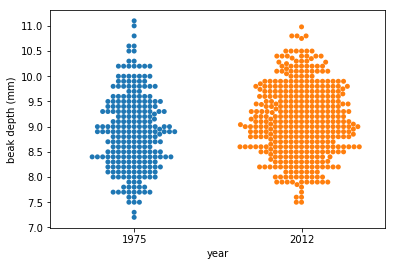

In [26]:
# The beak depth measurements in 1975 and 2012 in a bee swarm plot.
swaempltdf = df[['year', 'beak_depth']]

_ = sns.swarmplot(data=swaempltdf, x='year', y='beak_depth')

_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

plt.show()

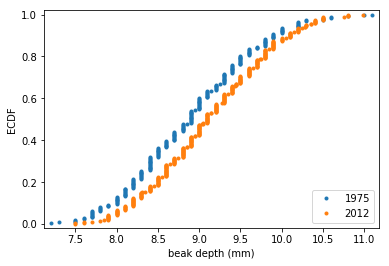

In [27]:
# The ECDFs for the 1975 and 2012 beak depth measurements
bd_1975 = df1['beak_depth']
bd_2012 = df2['beak_depth']

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    n = len(data)
    
    x = np.sort(data)

    y = np.arange(1, n+1) / n
    
    return x, y

# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

plt.show()

In [28]:
# Estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 
# and report a 95% confidence interval.
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# Compute the difference of the sample means
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22313275434242108 mm
95% confidence interval = [0.10595495 0.33762267] mm


In [30]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value: p
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)
print('p =', p)

#p-value suggests that there is a statistically significant difference. (changed over 37 years)

p = 0.0002


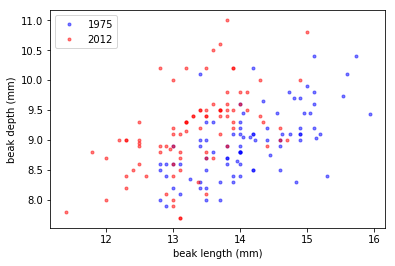

In [41]:
# Select related data
bd_parent_scandens_df = df.loc[(df['species'] == 'scandens') & (df['year'] == '1975')]
bd_offspring_scandens_df = df.loc[(df['species'] == 'scandens') & (df['year'] == '2012')]

bd_2012 = np.array(bd_parent_scandens_df['beak_depth'][:87])
bl_2012= np.array(bd_parent_scandens_df['beak_length'][:87])
bd_1975 = np.array(bd_offspring_scandens_df['beak_depth'][:87])
bl_1975 = np.array(bd_offspring_scandens_df['beak_length'][:87])


#bl_1975 = df1['beak_length']
#bl_2012 = df2['beak_length']

# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

plt.show()

In [42]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices
    inds = np.arange(len(x))

    # Initialize replicates
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(
                            bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(
                            bs_intercept_reps_2012, [2.5, 97.5])

print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.33248488 0.59114534]
1975: intercept = 2.3908752365842263 conf int = [0.60439443 4.27475947]
2012: slope = 0.5175162785483686 conf int = [0.35772423 0.67555901]
2012: intercept = 2.2639155792538874 conf int = [0.16334039 4.37537131]


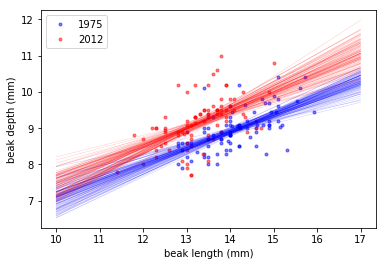

In [43]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

plt.show()

In [44]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

#The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. 
#The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.

1975: mean ratio = 1.5788823771858533 conf int = [1.55685406 1.60100936]
2012: mean ratio = 1.4596847700183153 conf int = [1.43451812 1.48655541]


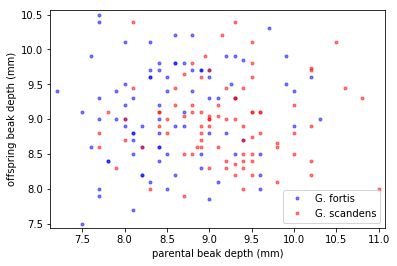

In [46]:
bd_parent_scandens_df = df.loc[(df['species'] == 'scandens') & (df['year'] == '1975')]
bd_parent_fortis_df = df.loc[(df['species'] == 'fortis') & (df['year'] == '1975')]

bd_offspring_fortis_df = df.loc[(df['species'] == 'fortis') & (df['year'] == '2012')]
bd_offspring_scandens_df = df.loc[(df['species'] == 'scandens') & (df['year'] == '2012')]

bd_parent_scandens = np.array(bd_parent_scandens_df['beak_depth'][:87])
bd_offspring_scandens = np.array(bd_offspring_scandens_df['beak_depth'][:87])
bd_parent_fortis = np.array(bd_parent_fortis_df['beak_depth'][:87])
bd_offspring_fortis = np.array(bd_offspring_fortis_df['beak_depth'][:87])

_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

plt.margins(0.02)

_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

plt.show()

In [47]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for single statistic."""

    inds = np.arange(len(x))

    # Initialize replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]


# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, pearson_r, size=1000)
bs_replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, pearson_r, size=1000)

conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)


G. scandens: -0.000957534281509133 [-0.23076129  0.2192785 ]
G. fortis: 0.12235575084501765 [-0.07846865  0.3502724 ]


In [48]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens,
                                     bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis,
                                   bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: -0.0007910484233018866 [-0.19054011  0.18311039]
G. fortis: 0.12321655258507634 [-0.10446739  0.32670532]


In [ ]:
# Initialize array of replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted,
                                      bd_offspring_scandens)

# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)
print('p-val =', p)

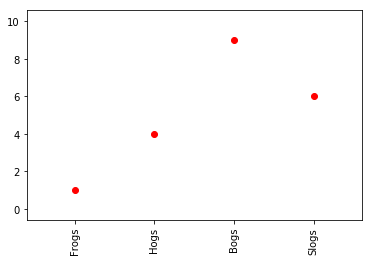